In [10]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
import alibi
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical



# tf.compat.v1.disable_eager_execution()
# import tensorflow as tf
# tf.keras.backend.clear_session()
%load_ext autoreload
%autoreload 2

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

# Create data

In [4]:
n = 10000
dims = 20
# Following is the synthetic dataset
# X, y = make_blobs(centers=3, cluster_std=18, n_features=dims, n_samples=n)


# Following is the California Housing dataset

california = fetch_california_housing(as_frame=True)
X = california.data.to_numpy()
target = california.target.to_numpy()
feature_names = california.feature_names

print(california.data.head())

y = np.zeros((target.shape[0],))
y[np.where(target > np.median(target))[0]] = 1

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  


# Standardize Data

In [5]:
mu = X.mean(axis=0)
sigma = X.std(axis=0)
X = (X - mu) / sigma

# Visualize train/test dataset

8 features


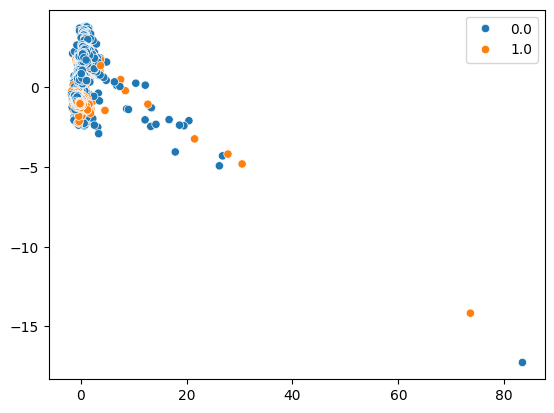

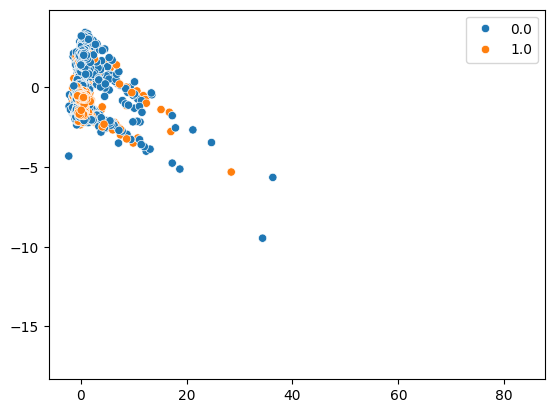

In [6]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train, y_train = X[:(n//5)*4], y[:(n//5)*4]
X_test, y_test = X[(n//5)*4:], y[(n//5)*4:]

dims = X_train.shape[1]
print(dims, "features")

pca = PCA(n_components=2)
embed_X_train = pca.fit_transform(X_train)
embed_X_test = pca.transform(X_test)
sns.scatterplot(x=embed_X_train[:, 0], y=embed_X_train[:, 1], hue=y_train)
x_lims = plt.xlim()
y_lims = plt.ylim()
plt.show()
sns.scatterplot(x=embed_X_test[:, 0], y=embed_X_test[:, 1], hue=y_test)
plt.xlim(x_lims)
plt.ylim(y_lims)
plt.show()

# Train model

In [7]:
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)
print("Model score: ", model.score(X_test, y_test))

#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
#test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

#BATCH_SIZE = 64

#train_dataset = train_dataset.batch(BATCH_SIZE)
#test_dataset = test_dataset.batch(BATCH_SIZE)

#model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
#model.fit(train_dataset,batch_size=BATCH_SIZE)

Model score:  0.7599683544303798


# Keras NN example:

In [8]:
# def nn_model():
#     x_in = Input(shape=(8,))
#     x = Dense(40, activation='relu')(x_in)
#     x = Dense(40, activation='relu')(x)
#     x_out = Dense(2, activation='softmax')(x) # 2 for California Housing
#     nn = Model(inputs=x_in, outputs=x_out)
#     nn.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#     return nn

# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)

# nn = nn_model()
# nn.summary()
# nn.fit(X_train, y_train, batch_size=64, epochs=500, verbose=0)

# score = nn.evaluate(X_test, y_test, verbose=0)
# print('Test accuracy: ', score[1])

# Save model
# nn.save('nn_california.h5', save_format='h5')

# Autoencoder

In [9]:
# Load and preprocess the dataset
# X_train = X_train.astype('float32') / 255.
# X_test = X_test.astype('float32') / 255.
# X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
# X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

dims = X_train.shape[1]

# Define the size of the encoding

X_train = X_train / np.max(X_train, axis=0).reshape(1, -1)
X_test = X_test / np.max(X_test, axis=0).reshape(1, -1)
encoding_dim = 8

# Define the input placeholder
input_img = Input(shape=(dims,))

# Define the encoder
encoded = Dense(encoding_dim, activation='relu')(input_img)

# Define the decoder
decoded = Dense(dims, activation='relu')(encoded)

# Combine the encoder and decoder into the autoencoder model
autoencoder = Model(input_img, decoded)

# Compile the model
autoencoder.compile(optimizer="Adam", loss='binary_crossentropy')

# Train the model
autoencoder.fit(X_train, X_train,
                epochs=20,
                batch_size=16,
                shuffle=True,
                validation_data=(X_test, X_test))

# Evaluate the model
decoded_imgs = autoencoder.predict(X_test)

print(autoencoder.evaluate(X_test, X_test))
print(X_test.shape,decoded_imgs.shape)

embed_X = pca.transform(X_test)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y_test)
x_lims = plt.xlim()
y_lims = plt.ylim()
plt.show()
embed_X = pca.transform(decoded_imgs)
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y_test)
plt.xlim(x_lims)
plt.ylim(y_lims)
plt.show()

print(autoencoder.summary())

Epoch 1/20


W0000 00:00:1741017869.876896    1781 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


RuntimeError: `tf.data.Dataset` only supports Python-style iteration in eager mode or within tf.function.

# Run GuidedByPrototypes

In [ ]:
# Load nn model:
# nn = load_model('nn_california.h5')

instance = X_test[[1]] #X_test[1].reshape((1,) + X_test[1].shape)
shape = instance.shape
print("Instance shape: ", shape)
print("X_train shape: ", X_train.shape)
enc = autoencoder.layers[1]
use_ae = True

if use_ae:
    cf = alibi.explainers.CounterfactualProto(model.predict_proba, shape, use_kdtree=False, theta=10., max_iterations=1000,
                            feature_range=(X_train.min(axis=0), X_train.max(axis=0)), 
                            c_init=1., c_steps=10, ae_model=autoencoder, enc_model=enc)
else:
    cf = alibi.explainers.CounterfactualProto(model.predict_proba, shape, use_kdtree=True, theta=10., max_iterations=1000,
                            feature_range=(X_train.min(axis=0), X_train.max(axis=0)), 
                            c_init=1., c_steps=10)
cf.fit(X_train)
explanation = cf.explain(instance)

Instance shape:  (1, 8)
X_train shape:  (8000, 8)


No counterfactual found!


In [ ]:
# Print class assignments
print(f'Original prediction: {explanation.orig_class}')
print(f'Counterfactual prediction: {explanation.cf["class"]}')

Original prediction: 0


TypeError: 'NoneType' object is not subscriptable

# Visualize CF

[[-0.16879414  0.5848523  -0.31311372 -0.27694288 -0.33244896  0.01441853
  -0.8342436   0.7186007 ]]


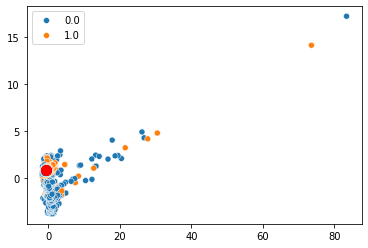

(1, 8)
[[-0.16879414  0.58485227 -0.31311371 -0.27694286 -0.33244897 -0.04626815
  -0.83424359  0.71860072]]
Instance class:  [1.]
Counterfactual class:  [0.]


In [ ]:
print(explanation.cf['X'])
#visualize the instance on our x_train dataset using a scatterplot like we did before
embed_X = pca.transform(X_train)
embed_instance = pca.transform(instance)
embed_cf = pca.transform(explanation.cf['X'])
sns.scatterplot(x=embed_X[:, 0], y=embed_X[:, 1], hue=y_train)
plt.scatter(embed_instance[:, 0], embed_instance[:, 1], color='black', s=100, label='instance')
plt.scatter(embed_cf[:, 0], embed_cf[:, 1], color='red', s=100, label='instance')
plt.show()


print("Instance shape: ", instance.shape)
print(instance)
print("Instance class: ", model.predict(instance))
print("Counterfactual class: ", model.predict(explanation.cf['X']))
# cf.explain(instance, target_class=[0,1,2])